# Examen Primer Parcial 
### Laboratorio de Aprendizaje Estadístico

José Armando Melchor Soto

--- 




### Librerías: 

In [70]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.formula.api as smf
import warnings
import numpy as np
from scipy import stats

warnings.simplefilter(action='ignore', category=FutureWarning)


### Dataset : 
Hitters

In [71]:
df = pd.read_csv('Hitters.csv')

----

### Visualización del Dataset

In [72]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


### Explicación de las variables 

A data frame with 322 observations of major league players on the following 20 variables.

AtBat Number of times at bat in 1986

Hits Number of hits in 1986

HmRun Number of home runs in 1986

Runs Number of runs in 1986

RBI Number of runs batted in in 1986

Walks Number of walks in 1986

Years Number of years in the major leagues

CAtBat Number of times at bat during his career

CHits Number of hits during his career

CHmRun Number of home runs during his career

CRuns Number of runs during his career

CRBI Number of runs batted in during his career

CWalks Number of walks during his career

League A factor with levels A and N indicating player’s league at the end of 1986

Division A factor with levels E and W indicating player’s division at the end of 1986

PutOuts Number of put outs in 1986

Assists Number of assists in 1986

Errors Number of errors in 1986

Salary 1987 annual salary on opening day in thousands of dollars

NewLeague A factor with levels A and N indicating player’s league at the beginning of 1987

---

### Se busca predecir el Salario de este Df

In [73]:
df['Salary']

0         NaN
1       475.0
2       480.0
3       500.0
4        91.5
        ...  
317     700.0
318     875.0
319     385.0
320     960.0
321    1000.0
Name: Salary, Length: 322, dtype: float64

In [74]:
target= 'Salary'

### Dummies

In [75]:
df= pd.get_dummies(df, columns=['League','NewLeague', 'Division' ])

### NaN's

In [76]:
df.isna().sum()


AtBat           0
Hits            0
HmRun           0
Runs            0
RBI             0
Walks           0
Years           0
CAtBat          0
CHits           0
CHmRun          0
CRuns           0
CRBI            0
CWalks          0
PutOuts         0
Assists         0
Errors          0
Salary         59
League_A        0
League_N        0
NewLeague_A     0
NewLeague_N     0
Division_E      0
Division_W      0
dtype: int64

La variable a predecir es la única que tiene bastantes NaN , para esto tenemos que llenarlas o quitarlas. En este caso vamos a quitarlas. 

In [77]:
df= df[df['Salary'].notnull()]

Comprobamos que se hayan quitado:

In [78]:
df['Salary']

1       475.0
2       480.0
3       500.0
4        91.5
5       750.0
        ...  
317     700.0
318     875.0
319     385.0
320     960.0
321    1000.0
Name: Salary, Length: 263, dtype: float64

### Analisis Bivariado

In [79]:
num_features = df.iloc[:, :-6].columns

In [80]:
df_numerical = df.iloc[:, :-6]
df_numerical = df_numerical.copy()

In [ ]:
df.drop(columns=['Attrition_Yes','BusinessTravel_Travel_Frequently','StandardHours','PerformanceRating','OverTime_Yes'
                 ,'BusinessTravel_Travel_Rarely','Department_Research & Development','Department_Sales', 'EducationField_Life Sciences',
                   'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'JobRole_Human Resources',
                   'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist',
                   'JobRole_Sales Executive', 'JobRole_Sales Representative', 'MaritalStatus_Married', 'MaritalStatus_Single', 'OverTime_Yes'
                    ], inplace=True)

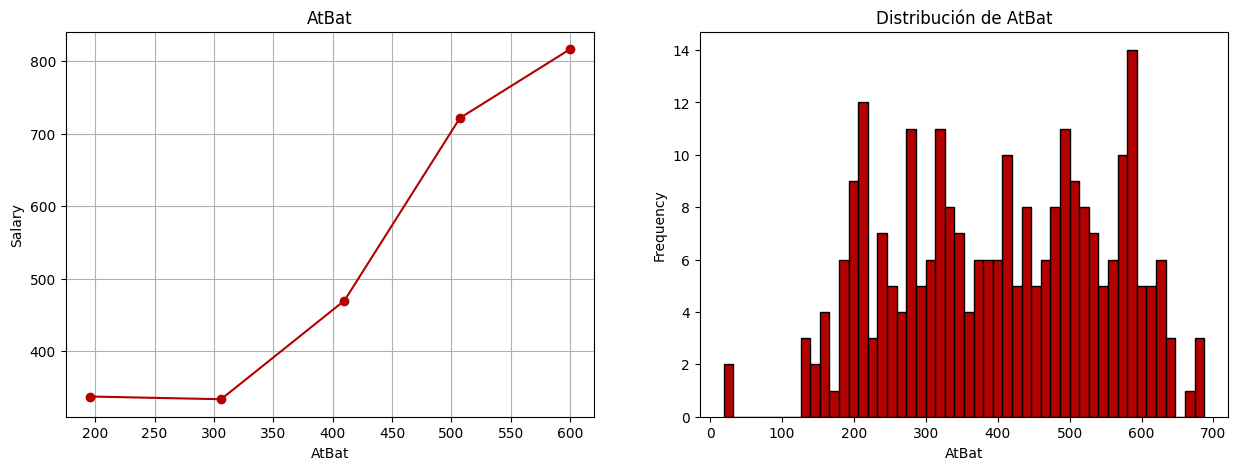

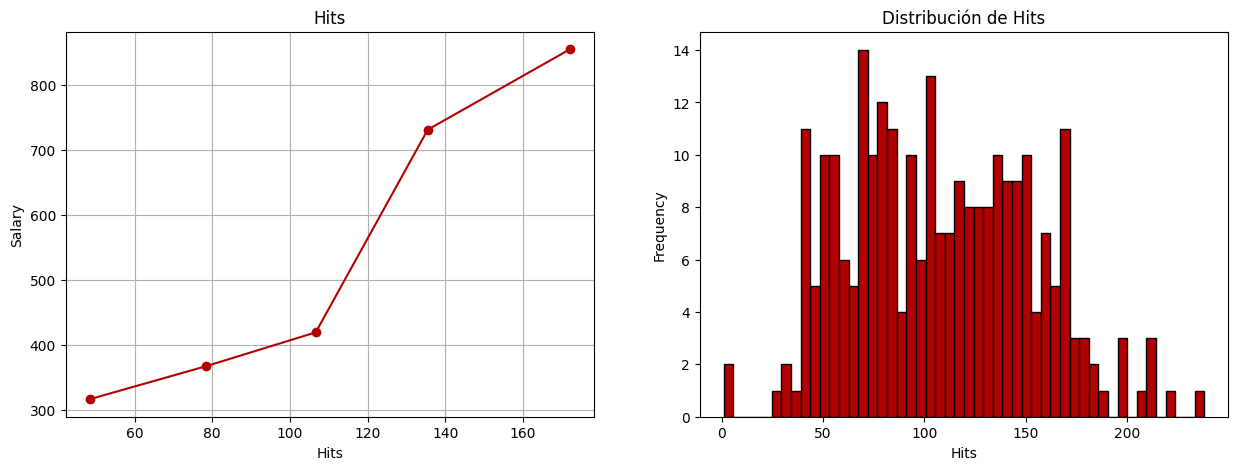

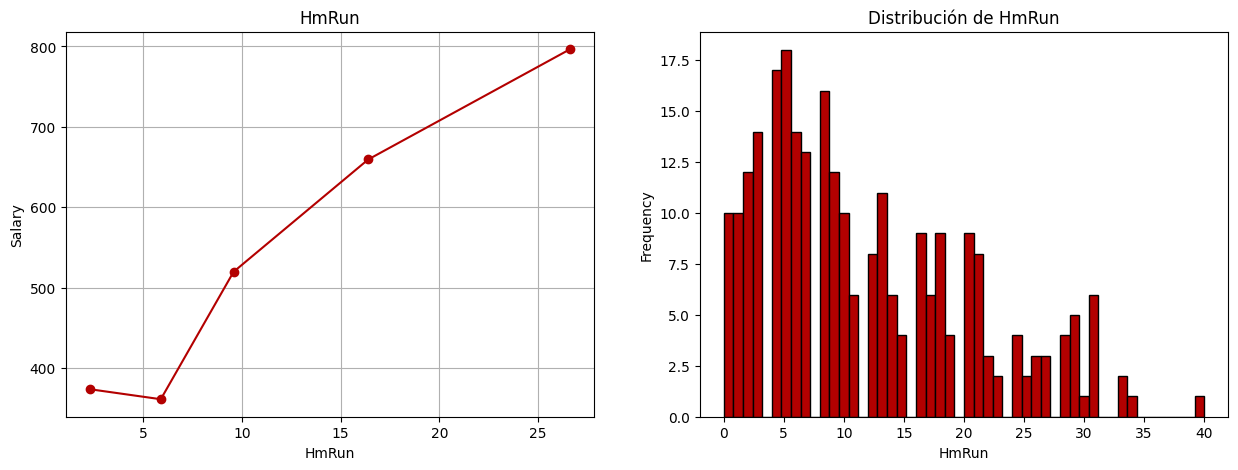

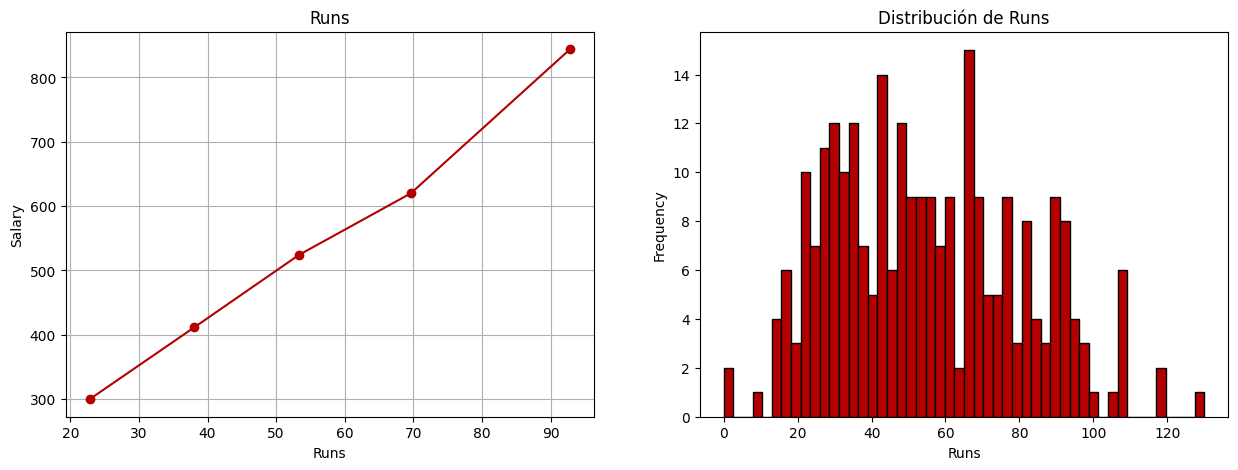

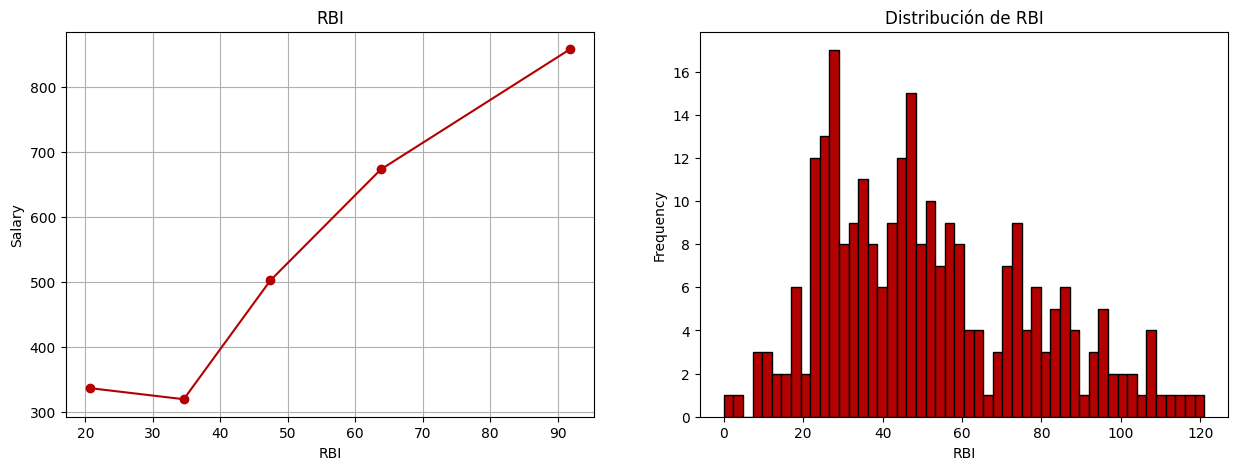

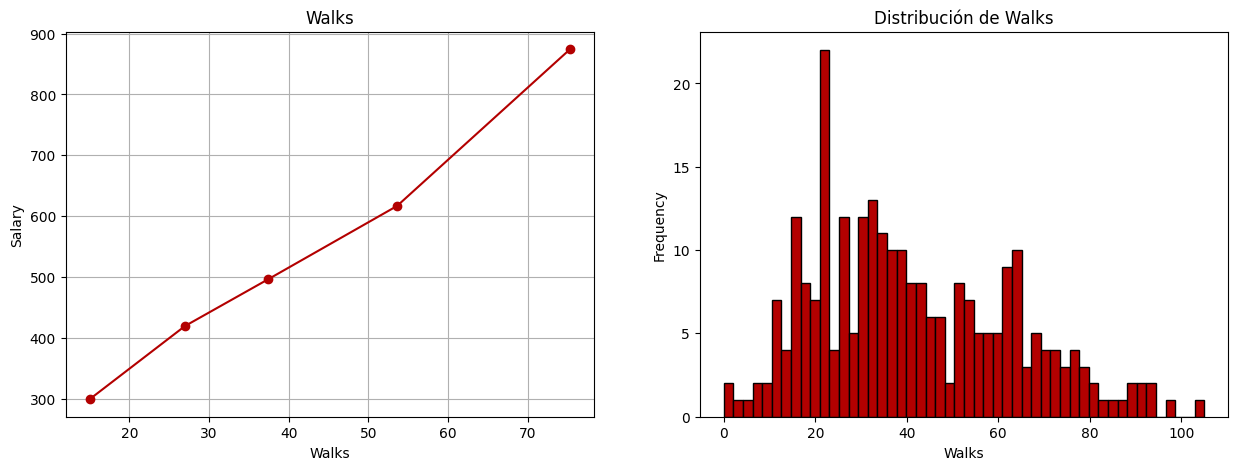

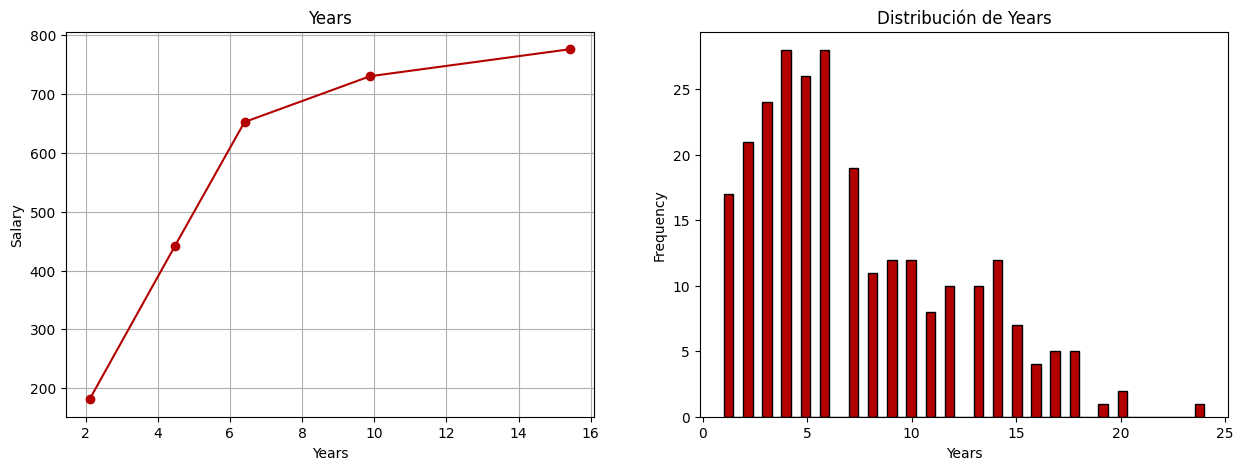

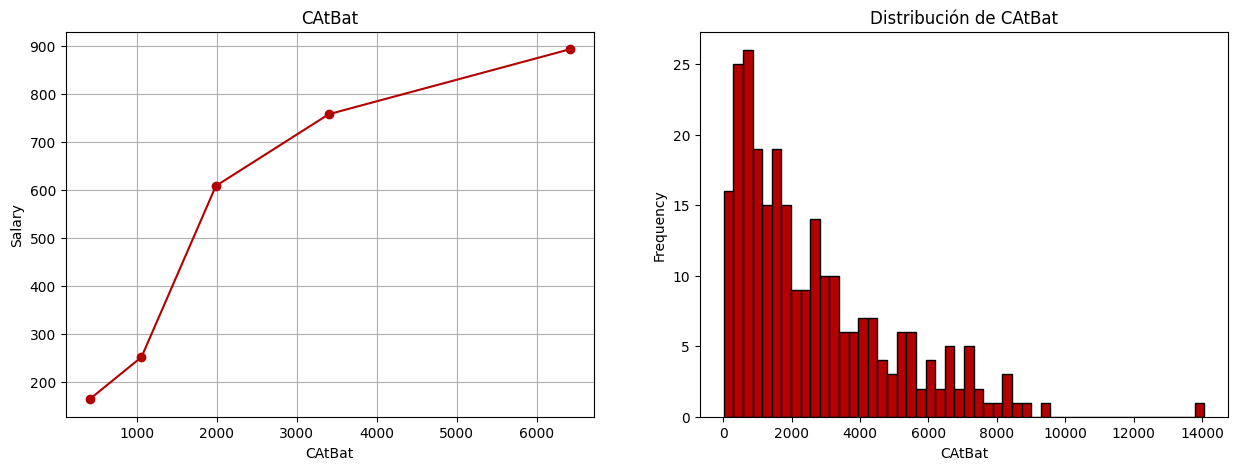

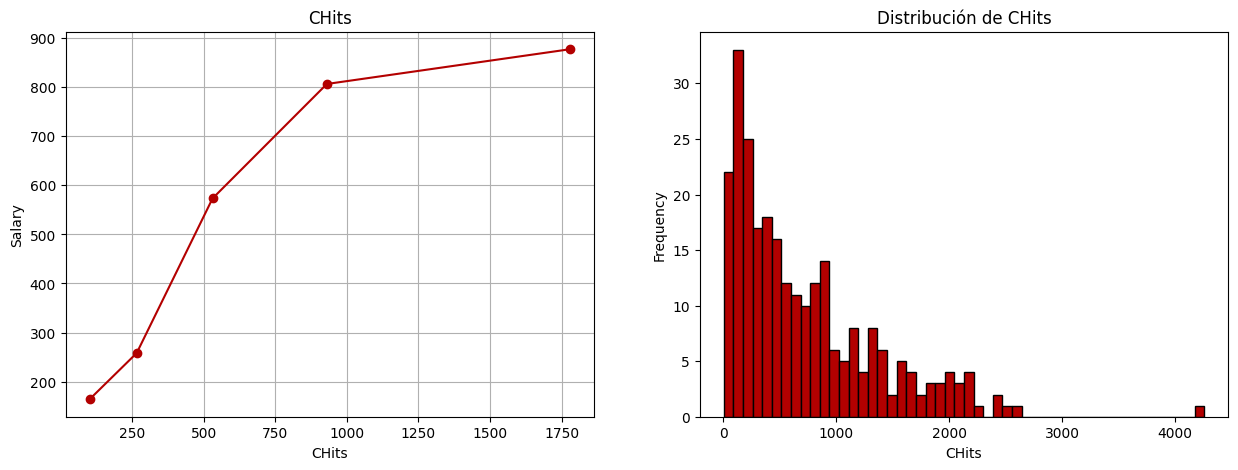

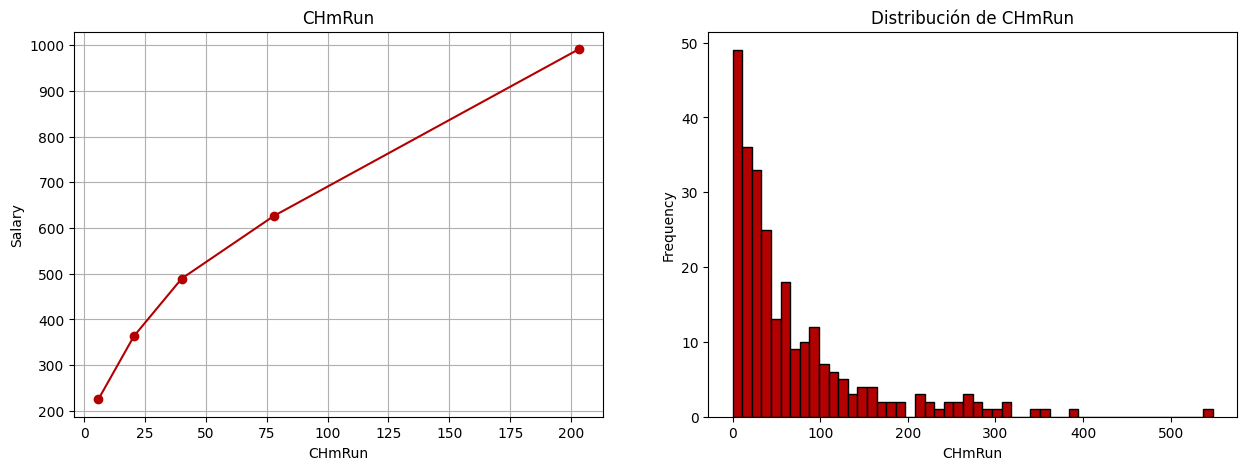

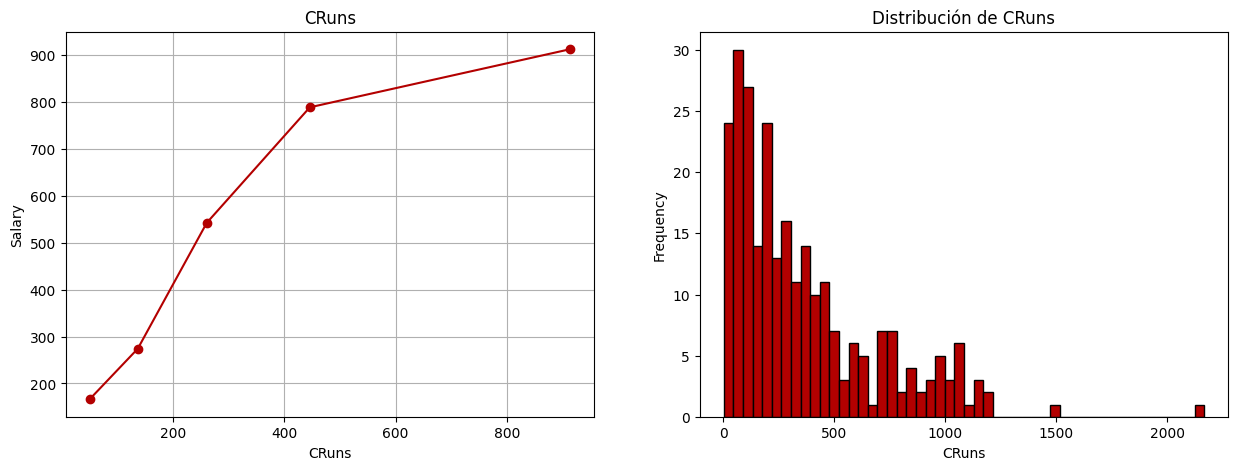

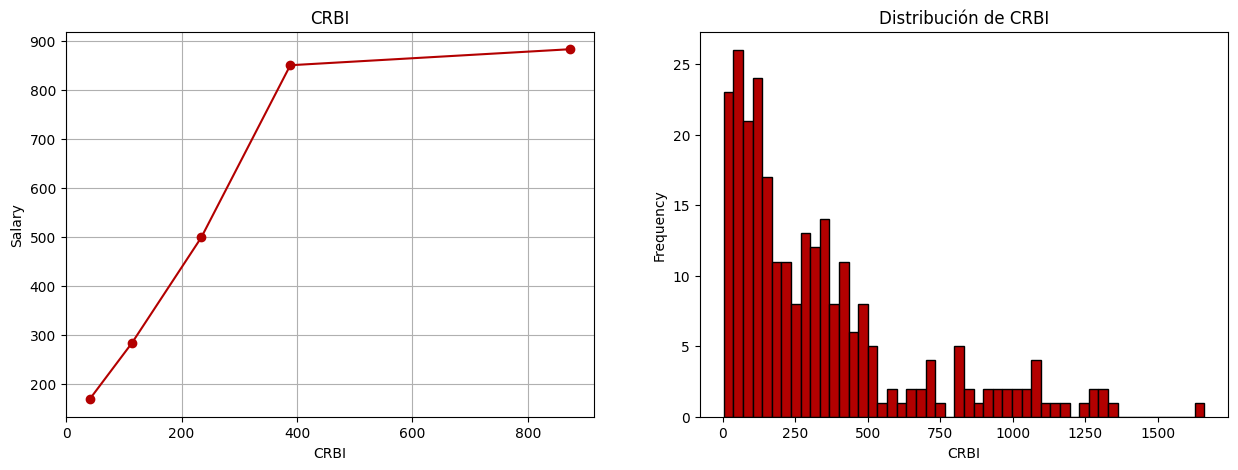

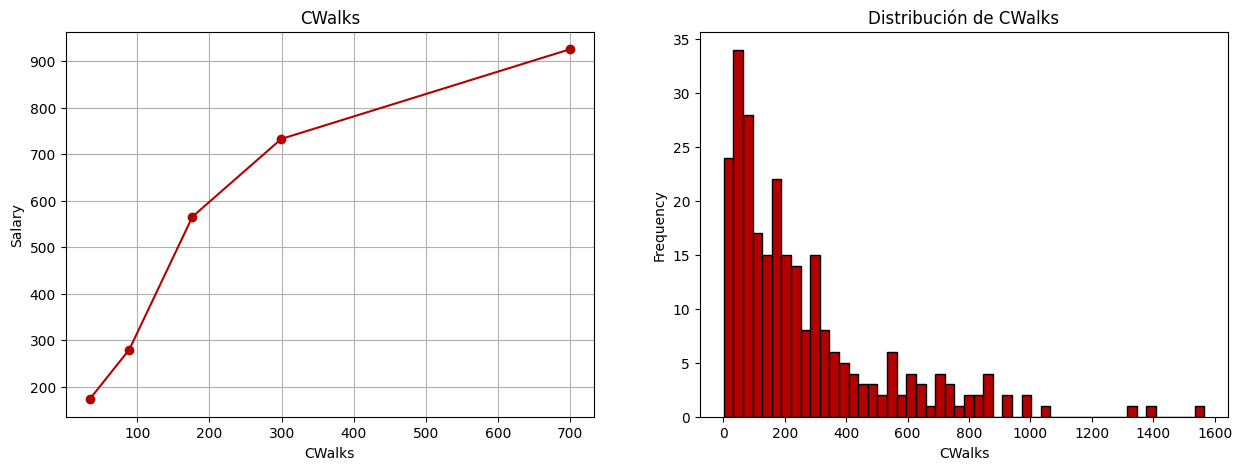

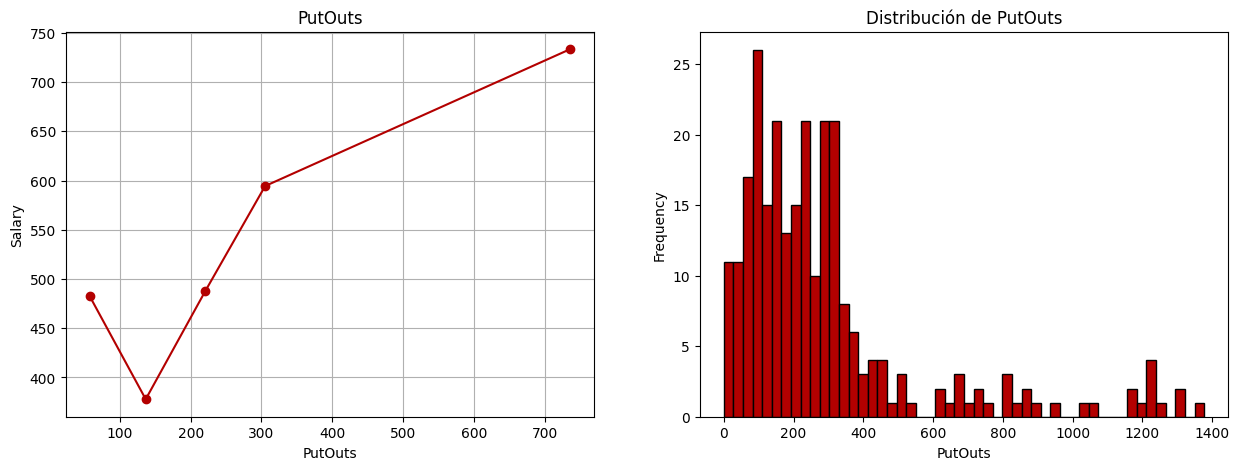

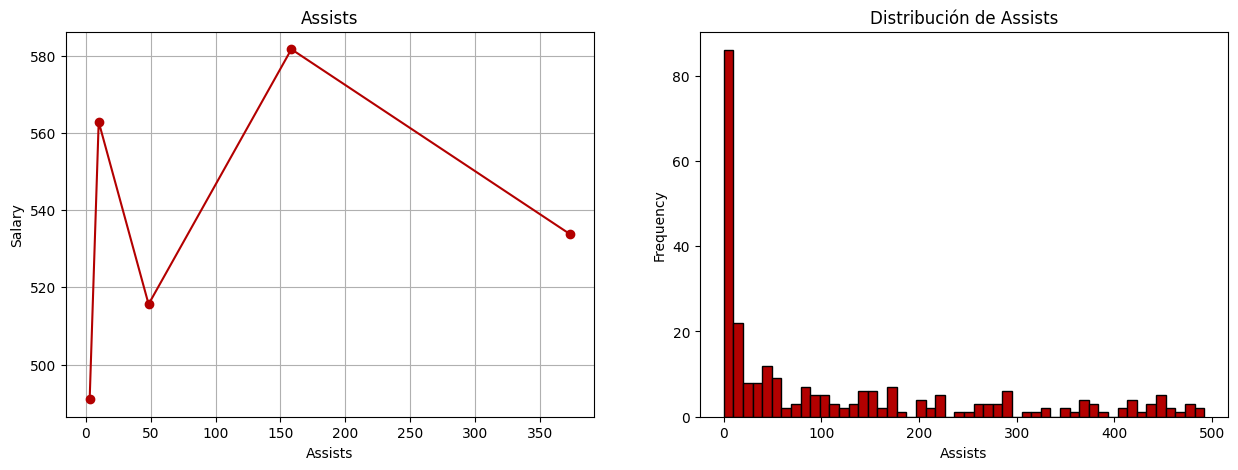

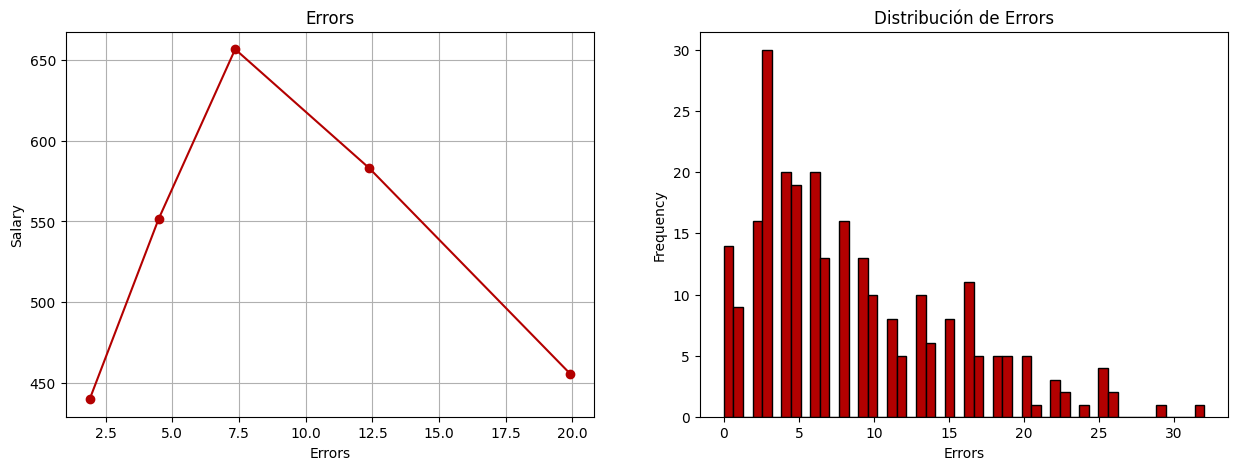

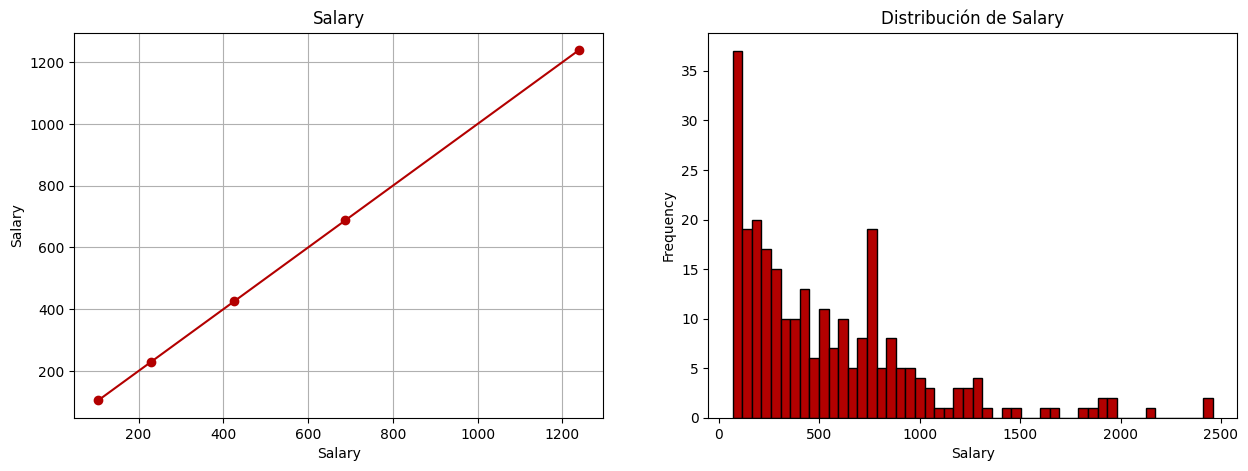

In [81]:
for feature in num_features:
    df_numerical[f'{feature}_bins'] = pd.qcut(df_numerical[feature], q=5, labels=False) + 1
    grouped = df_numerical.groupby(f'{feature}_bins').mean()
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
    
    axes[0].plot(grouped[feature], grouped['Salary'], color='#b30000', marker='o')
    axes[0].set_title(f'{feature}')
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel('Salary')
    axes[0].grid()

    axes[1].hist(df_numerical[feature], bins=50, color='#b30000', edgecolor='black')
    axes[1].set_title(f'Distribución de {feature}')
    axes[1].set_xlabel(feature)
    axes[1].set_ylabel('Frequency')

    plt.show()

Con el analisis bivariado podemos empezar los modelos.

### Modelo

Se pide que el modelo tenga: 

test: 20%
random_state: 42

Nuestro objetivo es: 

In [82]:
target= 'Salary'

### Función

In [83]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    gropuped = df_calibracion.groupby('bins').mean()
    
    plt.plot(gropuped.predicciones, gropuped.y, label="Modelo", marker="o")
    plt.plot(gropuped.predicciones, gropuped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

#### Regresión Lineal Simple

In [84]:
X = df.copy()
X = X.drop(columns=[target])
y = df[target]

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.2, random_state=42)

model= linear_model.LinearRegression().fit(X_train, y_train)
predicciones = model.predict(X_test)

mse = mean_squared_error(y_pred=predicciones, y_true=y_test)

print('Mean Squared Error:', mse)
print('R^2: ',r2_score(y_pred = predicciones, y_true = y_test))

Mean Squared Error: 128284.34549672343
R^2:  0.29074518557981466


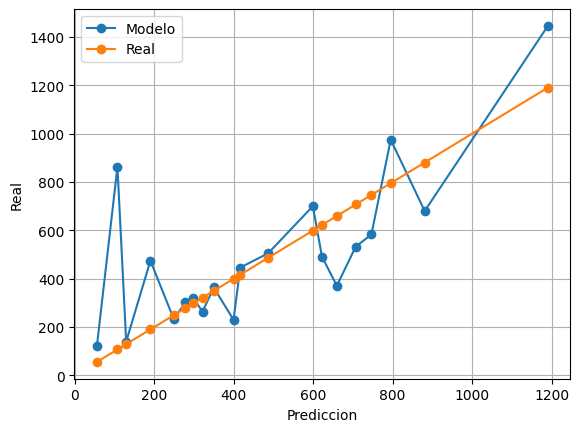

In [86]:
calibracion(predicciones, y_test, 20)

Con un $R^2 = 0.290745$, el modelo explica solo el $ 29 $% de la variabilidad de los datos, lo que indica que no es muy efectivo y podría necesitar mejoras.

Para mejorar el modelo podríamos añadirle Lasso y Ridge a la regresión lineal simple para ver si el $R^2$ mejora. 


### Lasso

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.2, random_state=42)

model= linear_model.Lasso().fit(X_train, y_train)
predicciones = model.predict(X_test)

mse = mean_squared_error(y_pred=predicciones, y_true=y_test)

print('Mean Squared Error:', mse)
print('R^2: ',r2_score(y_pred = predicciones, y_true = y_test))

Mean Squared Error: 127659.8547268276
R^2:  0.2941978522586254


c:\Users\ppmel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.948e+06, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(


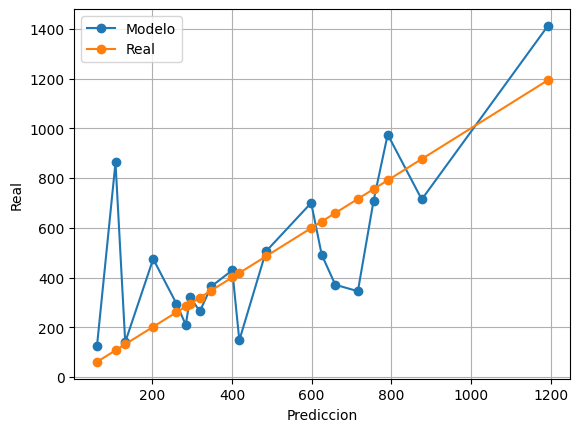

In [88]:
calibracion(predicciones, y_test, 20)


### Ridge

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.2, random_state=42)

model= linear_model.Ridge().fit(X_train, y_train)
predicciones = model.predict(X_test)

mse = mean_squared_error(y_pred=predicciones, y_true=y_test)

print('Mean Squared Error:', mse)
print('R^2: ',r2_score(y_pred = predicciones, y_true = y_test))

Mean Squared Error: 128083.67578002678
R^2:  0.291854642560901


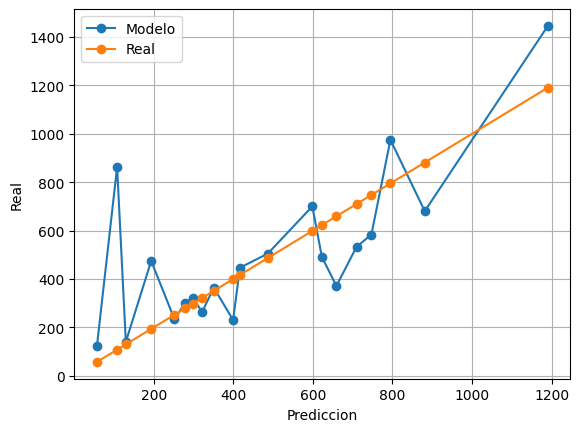

In [90]:
calibracion(predicciones, y_test, 20)


- $R^2 = 0.290745 - $ Regresión Simple
- $R^2 = 0.294197 - $ Lasso 
- $ R^2 = 0.291854 - $ Ridge

Con un $ R^2 = 0.294197 $ en **Lasso** y un $ R^2 = 0.291854 $ en **Ridge**, ambos modelos siguen explicando una pequeña parte de la variabilidad de los datos, lo que indica que aún están lejos de ser efectivos. Aunque el modelo **Lasso** muestra un ligero mejoramiento respecto a **Ridge**, ninguno de los dos alcanza un $ R^2 $ cercano a 1, lo que sugiere que ambos modelos no son adecuados para este conjunto de datos. Por lo tanto, aunque **Lasso** es el mejor de los tres, sigue siendo insuficiente como modelo predictivo. Para demás modelos de regresión polinomial nos vamos a enfocar en **Lasso**.


### Regresión Polinomial

#### Grado 2

In [91]:
degree = 2

# Aplicar StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Ajustar el modelo de regresión Lasso o ridge 
model = linear_model.Lasso().fit(X_train, y_train)
predicciones_poly_2 = model.predict(X_test)

mse = mean_squared_error(y_pred=predicciones_poly_2, y_true=y_test)
print('Mean Squared Error:', mse)
print('R^2 : ',r2_score(y_pred=predicciones_poly_2, y_true=y_test))


Mean Squared Error: 141904.0949955979
R^2 :  0.21544470471544952


c:\Users\ppmel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.275e+05, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(


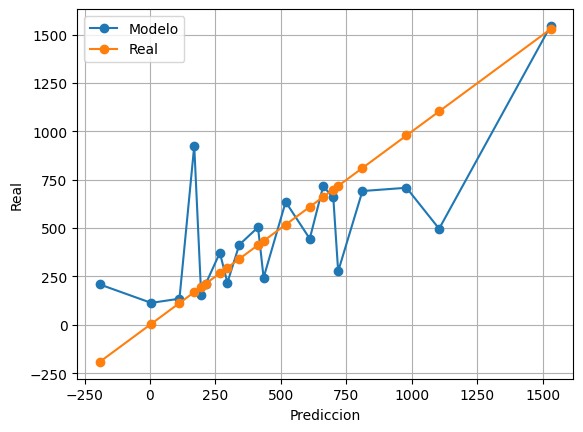

In [92]:
calibracion(predicciones_poly_2, y_test, 20)


#### Grado 3

In [93]:
degree = 3

# Aplicar StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Ajustar el modelo de regresión Lasso o ridge 
model = linear_model.Lasso().fit(X_train, y_train)
predicciones_poly_3 = model.predict(X_test)

mse = mean_squared_error(y_pred=predicciones_poly_3, y_true=y_test)
print('Mean Squared Error:', mse)
print('R^2 : ',r2_score(y_pred=predicciones_poly_3, y_true=y_test))

Mean Squared Error: 202665.74106453254
R^2 :  -0.12049254343138638


c:\Users\ppmel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.577e+05, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(


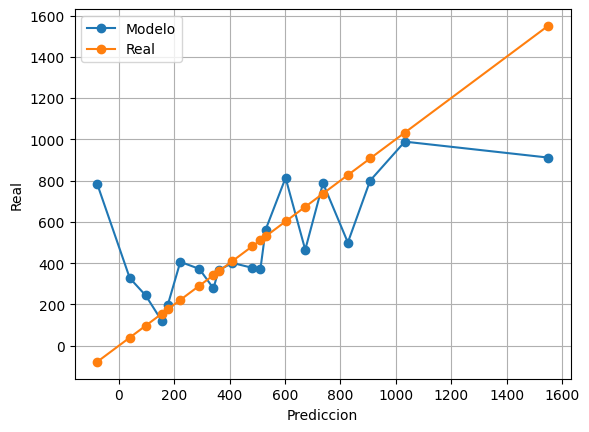

In [94]:
calibracion(predicciones_poly_3, y_test, 20)


#### Grado 4

In [95]:
degree = 4

# Aplicar StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Ajustar el modelo de regresión Lasso o ridge 
model = linear_model.Lasso().fit(X_train, y_train)
predicciones_poly_4 = model.predict(X_test)

mse = mean_squared_error(y_pred=predicciones_poly_4, y_true=y_test)
print('Mean Squared Error:', mse)
print('R^2 : ',r2_score(y_pred=predicciones_poly_4, y_true=y_test))


Mean Squared Error: 169531.04744895187
R^2 :  0.06270160142075087


c:\Users\ppmel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.444e+05, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(


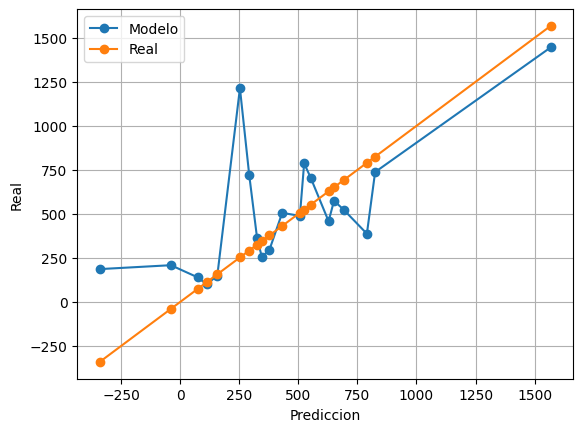

In [96]:
calibracion(predicciones_poly_4, y_test, 20)


In [97]:
print('R^2 Regresión Lineal: ',r2_score(y_pred=predicciones, y_true=y_test))
print('R^2 Polinomio de grado 2: ',r2_score(y_pred=predicciones_poly_2, y_true=y_test))
print('R^2 Polinomio de grado 3: ',r2_score(y_pred=predicciones_poly_3, y_true=y_test))
print('R^2 Polinomio de grado 4: ',r2_score(y_pred=predicciones_poly_4, y_true=y_test))


R^2 Regresión Lineal:  0.291854642560901
R^2 Polinomio de grado 2:  0.21544470471544952
R^2 Polinomio de grado 3:  -0.12049254343138638
R^2 Polinomio de grado 4:  0.06270160142075087


Ninguna de las regresiones polinomiales superó al de Lasso de la regresión Lineal , sigue estando muy por debajo de lo que se podría considerar bueno. 
Tenemos que seguir intentando con otros métodos para ver si el $ R^2 $ mejora. El más alto fue el del grado 2.

### KNN

In [98]:
X = df.copy()
X = X.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.2, random_state=42)

#### Con escalamiento

In [99]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [100]:
nn = []
r2 = []
r2_train = []
for i in range(1, 60):
    model = KNeighborsRegressor(n_neighbors=i).fit(X_train_scaled, y_train)
    predicciones = model.predict(X_test_scaled)
    r2.append(r2_score(y_true=y_test, y_pred=predicciones))
    nn.append(i)
    predicciones_train = model.predict(X_train_scaled)
    r2_train.append(r2_score(y_true=y_train, y_pred=predicciones_train))

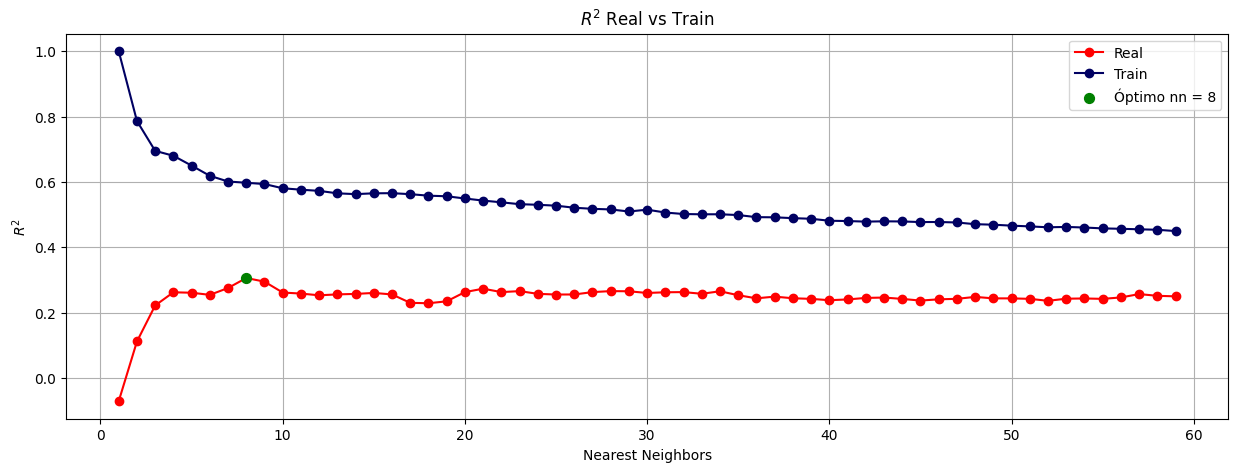

<Figure size 1000x500 with 0 Axes>

In [101]:
resultados = pd.DataFrame({'r2': r2, 'nn': nn, 'r2_train': r2_train})
nn_opt = resultados[resultados.r2 == max(resultados.r2)].nn.values[0]

plt.figure(figsize=(15, 5))
plt.plot(resultados.nn, resultados.r2, label='Real',color= 'red' ,marker='o')
plt.plot(resultados.nn, resultados.r2_train, label='Train', color= '#000062', marker='o')
plt.scatter(nn_opt, max(resultados.r2), label=f'Óptimo nn = {nn_opt}', color='green',s=50, zorder=3)
plt.grid()
plt.legend()
plt.title("$R^2$ Real vs Train")
plt.xlabel("Nearest Neighbors")
plt.ylabel("$R^2$")
plt.show()
plt.figure(figsize=(10, 5))


plt.show()


In [102]:
resultados = pd.DataFrame({
    'nn': nn,
    'r2': r2
})
resultados[resultados['r2'] == resultados['r2'].max()]

,nn,r2
7,8,0.305726


Los 8 vecinos son los que utizaremos para mejorar el modelo con $R^2 : 0.305726$ , tenemos que hacer una regresión multiple para poder cuales variables pueden ser significativas para nuestro modelo , con una prueba estadistica podemos darnos cuenta de que tan buenas son cada una y asi ir descartando cada una de ellas. 

### Regresión Múltiple

In [103]:
formula = 'Salary ~ ' + ' + '.join(df.drop([]))  

# Ajustar el modelo OLS
model = smf.ols(formula, data=df).fit()

# Imprimir el resumen del modelo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.438e+30
Date:                Fri, 21 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:38:05   Log-Likelihood:                 6892.9
No. Observations:                 263   AIC:                        -1.374e+04
Df Residuals:                     242   BIC:                        -1.367e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.457e-13   1

En esta vemos que hay bastantes variables que estadisticamente no son significativas para el modelo , vamos a quitarlas y ver si mejora el p-value y coeficientes.

In [104]:
model = smf.ols('Salary ~ ' + ' + '.join(df.columns.drop(['Salary','Assists', 'CHmRun','CHits', 'Years', 'RBI', 'Errors', 'Runs','HmRun', 'Division_W', 'League_A', 'NewLeague_N', 'NewLeague_A',
                                                            'League_N', 'CAtBat'])), data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     35.54
Date:                Fri, 21 Feb 2025   Prob (F-statistic):           2.02e-37
Time:                        11:38:05   Log-Likelihood:                -1881.3
No. Observations:                 263   AIC:                             3781.
Df Residuals:                     254   BIC:                             3813.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -6.6278     63

Al hacer el drop de todas las variables con un p-value mayor a 0.05, el modelo mejora notablemente. Ahora, todas las variables que quedaron tienen un p-value por debajo de 0.05, lo que significa que son estadísticamente significativas. Esto indica que las variables restantes son importantes y tienen un impacto real en el modelo.

### Modelo nuevo de Regresión Lineal Múltiple (Variables significativas)

#### Lasso

In [105]:
X_var = X[['Division_E', 'AtBat', 'Hits', 'Walks', 'CRuns', 'CRBI', 'CWalks', 'PutOuts']]

X_train, X_test, y_train, y_test = train_test_split(X_var, df[target], test_size=0.2, random_state=42)

model_linear = linear_model.Lasso().fit(X_train, y_train)
predicciones_lineal = model_linear.predict(X_test)
print('R^2 :',r2_score(y_pred = predicciones_lineal, y_true = y_test))

R^2 : 0.2888541158281829


### Polinomial 
#### Grado 2

In [106]:
degree = 2

# Aplicar StandardScaler
X_scaled = StandardScaler().fit_transform(X_var)

# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Ajustar el modelo de regresión Lasso o ridge 
model = linear_model.Lasso().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_poly_2 = model.predict(X_test)
print('R^2 :', r2_score(y_pred=predicciones_poly_2, y_true=y_test))

R^2 : 0.33022622367250853


c:\Users\ppmel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.233e+06, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(


Se puede observar que en la Polinomial G2, hay una ligera mejoría en el $ R^2 $ , pero se puede mejorar aplicando otros métodos. Probaremos con una Prueba AB para ver que tan significativas son las ligas y divisiones para el salario.

### Prueba AB 

In [107]:
def AB_test(test, control):
    # Mu
    mu_test= test.mean()
    mu_control= control.mean()

    # SE
    se_test= test.sem()
    se_control= control.sem()
    # Differences
    mu_diff= mu_control - mu_test
    se_diff= np.sqrt((test.var() / len(test)) +( control.var() / len(control)))
    # Z score and p value 
    z= mu_diff / se_diff
    p_value= stats.norm.cdf(z)


    print(f"Variable test entre {mu_test - 2*se_test} y {mu_test + 2*se_test}")
    print(f"Variable control entre {mu_control - 2*se_control} y {mu_control + 2*se_control}")
    print(f"scores de Z : {z}")
    print(f"El p value es : {p_value}")

    return

#### AB test para League A y League N 

In [108]:
LeagueA = df[df['League_A'] == 1].Salary
LeagueN = df[df['League_N'] == 1].Salary

In [109]:
AB_test(LeagueA, LeagueN)

Variable test entre 463.154829247405 y 620.8442642777749
Variable control entre 450.61682730280836 y 607.6181726971918
scores de Z : -0.2315660047996796
El p value es : 0.40843755703790957


In [110]:
result = smf.ols('Salary ~ League_A + League_N', data=df).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,357.0390,18.609,19.187,0.000,320.397,393.681
League_A[T.True],184.9605,28.915,6.397,0.000,128.024,241.897
League_N[T.True],172.0785,29.922,5.751,0.000,113.159,230.998


En esta prueba se calculó la diferencia de salarios que hay entre la League A + League N, donde se ve que la diferencia de salarios entre ambas ligas no es estadísticamente significativa.

#### AB test para New League A y New League N

In [111]:
NLeagueA = df[df['NewLeague_A'] == 1].Salary
NLeagueN = df[df['NewLeague_N'] == 1].Salary

In [112]:
AB_test(LeagueA, LeagueN)

Variable test entre 463.154829247405 y 620.8442642777749
Variable control entre 450.61682730280836 y 607.6181726971918
scores de Z : -0.2315660047996796
El p value es : 0.40843755703790957


In [113]:
result = smf.ols('Salary ~ NewLeague_A + NewLeague_N', data=df).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,357.2223,18.629,19.176,0.000,320.540,393.904
NewLeague_A[T.True],179.8907,28.809,6.244,0.000,123.162,236.619
NewLeague_N[T.True],177.3316,30.086,5.894,0.000,118.089,236.575


En esta prueba se calculó la diferencia de salarios que hay entre la NewLeague A + NewLeague N, donde se ve que la diferencia de salarios entre ambas ligas no es estadísticamente significativa.

#### AB test para Division E y Division W

In [114]:
DivisionE = df[df['Division_E'] == 1].Salary
DivisionW = df[df['Division_W'] == 1].Salary

In [115]:
AB_test(LeagueA, LeagueN)

Variable test entre 463.154829247405 y 620.8442642777749
Variable control entre 450.61682730280836 y 607.6181726971918
scores de Z : -0.2315660047996796
El p value es : 0.40843755703790957


In [116]:
result = smf.ols('Salary ~ Division_E + Division_W', data=df).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,358.3827,18.236,19.652,0.000,322.474,394.291
Division_E[T.True],265.8886,28.998,9.169,0.000,208.790,322.988
Division_W[T.True],92.4941,28.669,3.226,0.001,36.043,148.946


En esta prueba se calculó la diferencia de salarios que hay entre la División E y División W, donde se ve que la diferencia de salarios entre ambas divisiones no es estadísticamente significativa. Si bien las pruebas de hipótesis sugieren que no hay una diferencia estadísticamente significativa en los salarios entre las ligas y divisiones analizadas, la regresión lineal indica que la afiliación a cada grupo sí influye en el salario.


### Feature engenieering 

In [ ]:
# Desempeño Ofensivo
df['Hits_Per_AtBat'] = df['Hits'] / df['AtBat']  # Tasa de hits por turno al bate
df['HomeRuns_Per_Hit'] = df['HmRun'] / df['Hits']  # Proporción de jonrones por hit

# Desempeño a lo largo de la carrera
df['Career_RBI_Per_AtBat'] = df['CRBI'] / df['CAtBat']  # Carreras impulsadas por turno al bate
df['Career_Runs_Per_Hit'] = df['CRuns'] / df['CHits']  # Carreras anotadas por hit
df['Career_Hits_Per_Year'] = df['CHits'] / df['Years']  # Hits por año de carrera

# Transformaciones logarítmica y raíz cuadrada
df['Log_Career_Runs'] = np.log(df['CRuns'])  # Logaritmo de carreras anotadas en la carrera
df['Sqrt_Career_Hits'] = np.sqrt(df['CHits'])  # Raíz cuadrada de los hits en la carrera



In [118]:
pd.DataFrame(df.isnull().sum()).T

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,NewLeague_N,Division_E,Division_W,Hits_Per_AtBat,HomeRuns_Per_Hit,Career_RBI_Per_AtBat,Career_Runs_Per_Hit,Career_Hits_Per_Year,Log_Career_Runs,Sqrt_Career_Hits
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Nueva Regresión Lineal con Feature engenieering 

In [119]:
X = df.copy()
X = X.drop(columns=[target])
y = df[target]

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.2, random_state=42)

model = linear_model.LinearRegression().fit(X_train, y_train)
predicciones = model.predict(X_test)

mse = mean_squared_error(y_pred=predicciones, y_true=y_test)

print('Mean Squared Error:', mse)
print('R^2: ', r2_score(y_pred=predicciones, y_true=y_test))

Mean Squared Error: 56502.29109921073
R^2:  0.6876117515920167


Se obtuvo un $R^2$ bastante mayor del que estabamos viendo en modelos anteriores.

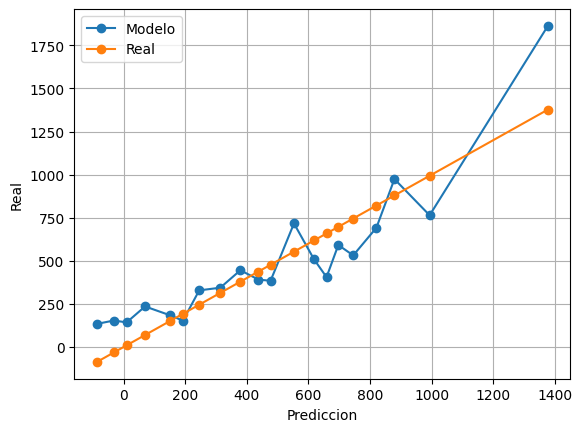

In [121]:
calibracion(predicciones, y_test, 20)

Haciendo Featuring Eng.,  nos da un $ R^2 $ muy bueno a comparación del primero que nos estaba dando , parece ser que el modelo se comporta de manera estable y no tiene overfitting. Se utilizaron las mejores correlaciones que pudiera tener la variable de Salario. 

### Regresión Polinomial Feature Eng.

#### Grado 2

#### LASSO 

In [122]:
degree = 2

# Aplicar StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Crossvalidation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Ajustar el modelo de regresión Lasso o ridge 
model = linear_model.Lasso().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_poly2_fe = model.predict(X_test)
mse = mean_squared_error(y_pred=predicciones_poly2_fe, y_true=y_test)

print('Mean Squared Error:', mse)
print('R^2 : ',r2_score(y_pred=predicciones_poly2_fe, y_true=y_test))

Mean Squared Error: 104115.74057873242
R^2 :  0.42436787609229276


c:\Users\ppmel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.075e+05, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(


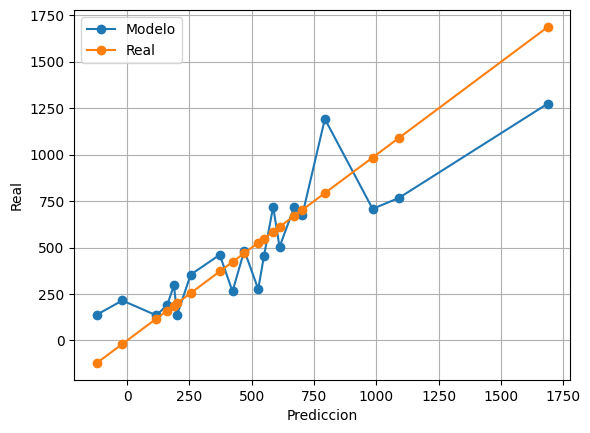

In [123]:
calibracion(predicciones_poly2_fe, y_test, bins=20)

#### Grado 3

In [124]:
degree =3

# Aplicar StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Crossvalidation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Ajustar el modelo de regresión Lasso o ridge 
model = linear_model.Lasso().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_poly3_fe = model.predict(X_test)
mse = mean_squared_error(y_pred=predicciones_poly3_fe, y_true=y_test)

print('Mean Squared Error:', mse)
print('R^2 : ',r2_score(y_pred=predicciones_poly3_fe, y_true=y_test))

Mean Squared Error: 276260.84445700113
R^2 :  -0.5273830427884796


c:\Users\ppmel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.181e+05, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(


Se observa que para cuando hacemos la Regresión de Polinomio 3 , el $R^2$ baja significativamente. Así que no tiene caso quedarse con el $R^2$ de estas regresiones. Probaremos a hacer un último modelo con las variables significativas para predecir el salario.

#### Nuevo modelo de regresión Lineal

In [125]:
numerical_features = df.columns.drop(['Salary' ,'League_A', 'League_N', 'Division_E', 'Division_W', 'NewLeague_A', 'NewLeague_N', 'Years'])

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, df[target], test_size=0.2, random_state=42)
# Crea funcion bins para las variables numericas 
def create_bins(X, numeric_vars, bins):
    for var in numeric_vars:
        X[f'{var}_bin'] = pd.qcut(X[var], q = bins, labels=False, duplicates='drop') + 1
    return X
X_train = create_bins(X_train, numerical_features, 10)
X_test = create_bins(X_test, numerical_features, 10)

bins_features = [i for i in X_train.keys() if 'bin' in i]
cat_features = [i for i in X_train.keys() if 'bin' not in i]

final_features = bins_features + cat_features
X_train = pd.get_dummies(X_train[final_features], columns=bins_features, drop_first=True)
X_test = pd.get_dummies(X_test[final_features], columns=bins_features, drop_first=True)

In [127]:
model = smf.ols('Salary ~ ' + ' + '.join(df.columns.drop(['Salary', 'CHmRun', 'Assists', 'CWalks', 'Runs', 'Errors', 'RBI', 'HmRun', 'Hits', 
                                                          'AtBat','Division_W','CHits','CRuns','League_A','League_N', 'NewLeague_A',
                                                          'NewLeague_N','Career_RBI_Per_AtBat','HomeRuns_Per_Hit', 'Years','Hits_Per_AtBat', 'Log_Career_Runs' ,'CAtBat'])), data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     35.85
Date:                Fri, 21 Feb 2025   Prob (F-statistic):           1.15e-34
Time:                        11:38:07   Log-Likelihood:                -1890.0
No. Observations:                 263   AIC:                             3796.
Df Residuals:                     255   BIC:                             3824.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -332.9151 

In [128]:
X_OLS = X.drop(columns=[ "Division_E",
    "Walks",
    "PutOuts",
    "Career_Hits_Per_Year",
])

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X_OLS, df[target], test_size=0.2, random_state=42)

model_linear = linear_model.LinearRegression().fit(X_train, y_train)
predicciones_lineal = model_linear.predict(X_test)
print('R^2 :',r2_score(y_pred = predicciones_lineal, y_true = y_test))

R^2 : 0.6611491322058232


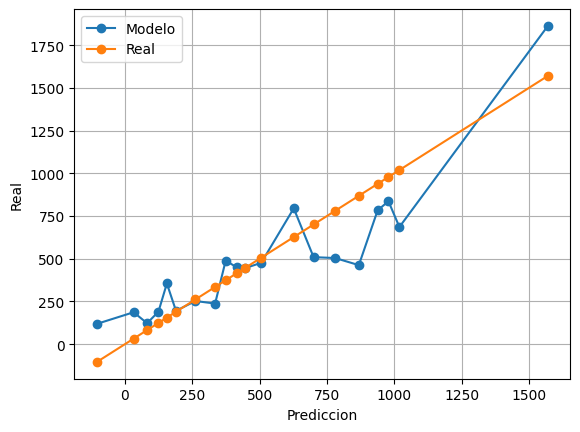

In [130]:
calibracion(predicciones_lineal, y_test, 20)

Aunque se acerca demasiado a lo que estabamos haciendo en el Features Eng., todavia no es el mejor.

### KNN con Feature Eng.

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X_OLS, df[target], test_size=0.2, random_state=42)

# Escalar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [132]:
nn = []
r2 = []
r2_train = []
for i in range(1, 50):
    model = KNeighborsRegressor(n_neighbors=i).fit(X_train_scaled, y_train)
    predicciones = model.predict(X_test_scaled)
    r2.append(r2_score(y_true=y_test, y_pred=predicciones))
    nn.append(i)
    predicciones_train = model.predict(X_train_scaled)
    r2_train.append(r2_score(y_true=y_train, y_pred=predicciones_train))

R^2 con 8 neighbors: 0.2303


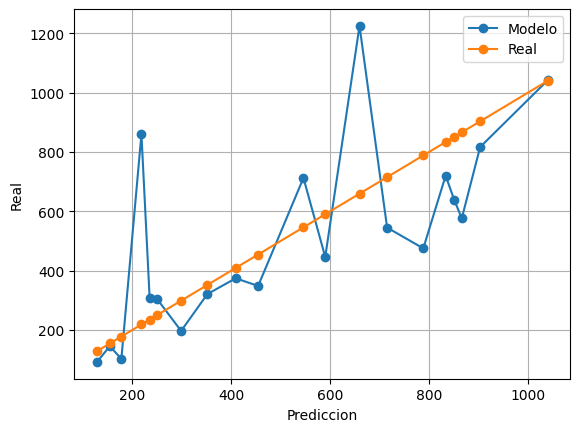

In [133]:
model = KNeighborsRegressor(n_neighbors=nn_opt).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
nn_opt_nbr = r2_score(y_true=y_test, y_pred=predicciones)

print(f"R^2 con {nn_opt} neighbors: {nn_opt_nbr:.4f}")
calibracion(predicciones, y_test, 20)

KNN ya no fue tan bueno , asi que descartamos usar este prodecimiento para este modelo.

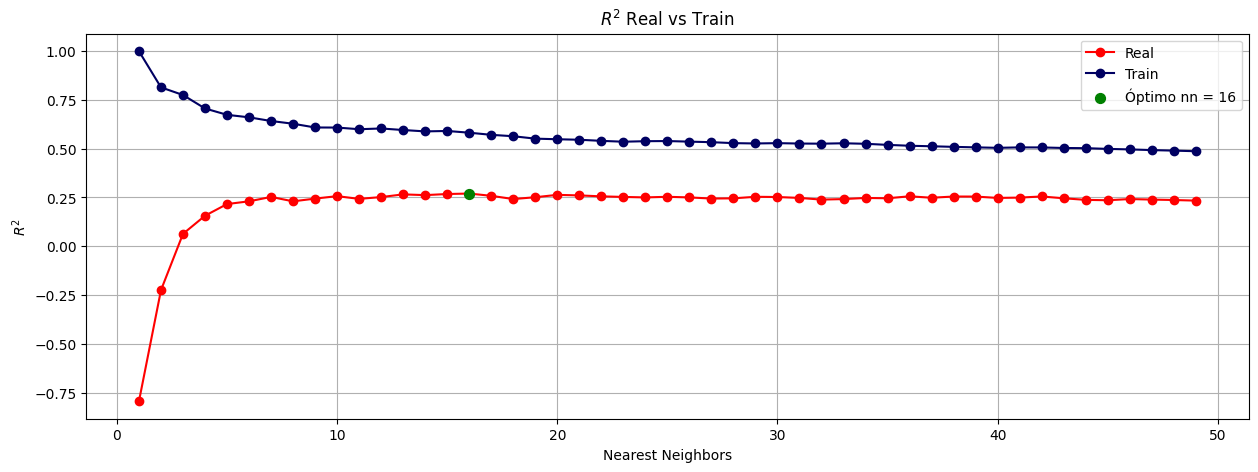

<Figure size 1000x500 with 0 Axes>

In [134]:
resultados = pd.DataFrame({'r2': r2, 'nn': nn, 'r2_train': r2_train})
nn_opt = resultados[resultados.r2 == max(resultados.r2)].nn.values[0]

plt.figure(figsize=(15, 5))
plt.plot(resultados.nn, resultados.r2, label='Real',color= 'red' ,marker='o')
plt.plot(resultados.nn, resultados.r2_train, label='Train', color= '#000062', marker='o')
plt.scatter(nn_opt, max(resultados.r2), label=f'Óptimo nn = {nn_opt}', color='green',s=50, zorder=3)
plt.grid()
plt.legend()
plt.title("$R^2$ Real vs Train")
plt.xlabel("Nearest Neighbors")
plt.ylabel("$R^2$")
plt.show()
plt.figure(figsize=(10, 5))


plt.show()


### Nueva Regresión Polinomial 

In [ ]:
degree =2

# Aplicar StandardScaler
from sklearn.preprocessing import StandardScaler # type: ignore
scaler = StandardScaler().fit(X_OLS)
X_scaled = scaler.transform(X_OLS)

# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Crossvalidation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Ajustar el modelo de regresión Lasso o ridge 
model = linear_model.Lasso().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_poly2_fe = model.predict(X_test)
mse = mean_squared_error(y_pred=predicciones_poly2_fe, y_true=y_test)

print('Mean Squared Error:', mse)
print('R^2 : ',r2_score(y_pred=predicciones_poly2_fe, y_true=y_test))

Mean Squared Error: 84512.53523482595
R^2 :  0.5327495162245901


c:\Users\ppmel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e+05, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(


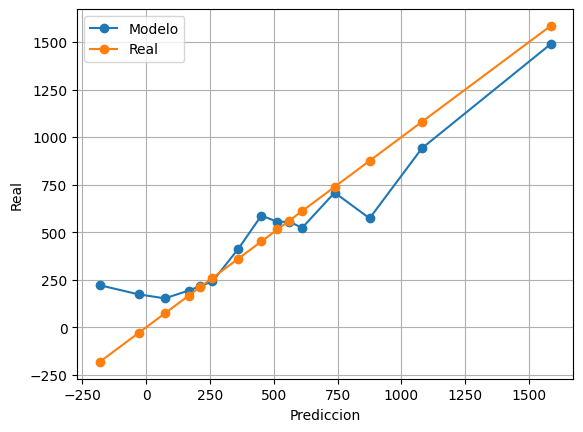

In [136]:
calibracion(predicciones_poly2_fe, y_test, 15)

In [ ]:
degree = 3

# Aplicar StandardScaler
from sklearn.preprocessing import StandardScaler # type: ignore
scaler = StandardScaler().fit(X_OLS)
X_scaled = scaler.transform(X_OLS)

# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Crossvalidation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Ajustar el modelo de regresión Lasso o ridge 
model = linear_model.Lasso().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_poly3_fe = model.predict(X_test)
mse = mean_squared_error(y_pred=predicciones_poly3_fe, y_true=y_test)

print('Mean Squared Error:', mse)
print('R^2 : ',r2_score(y_pred=predicciones_poly3_fe, y_true=y_test))

Mean Squared Error: 91341.07010982
R^2 :  0.4949961082247857


c:\Users\ppmel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.994e+05, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(


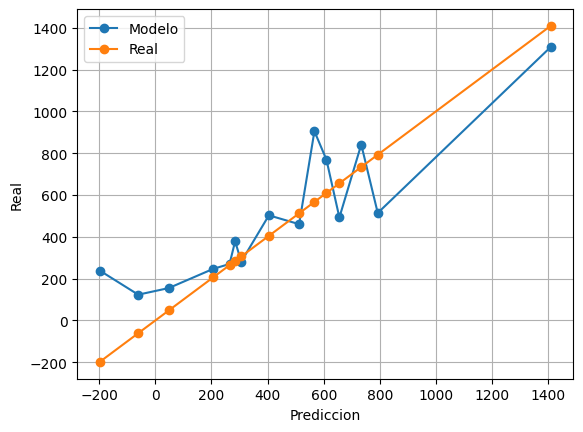

In [138]:
calibracion(predicciones_poly3_fe, y_test, 15)

Con polinomial ya no sube más.

---

## Conclusión

El coeficiente de determinación $R^2 $ mejoró significativamente en comparación con los modelos anteriores, alcanzando un máximo de **0.6876** en la regresión Lineal. Esto indica que el modelo explica un **68.76%** de la variabilidad de los datos, reflejando una mejora considerable en el ajuste.  

Para evitar **overfitting**, se aplicó **validación cruzada (cross-validation)**, asegurando que el modelo no estuviera sobreajustado a los datos de entrenamiento y mantuviera una buena capacidad de generalización.  

Por último, con la creación de nuevas **variables (Feature Engineering)**, el modelo para predecir los salarios mostró una mejora significativa. Este paso resultó ser el factor más determinante en el rendimiento de los modelos predictivos, se aplicaron varios OLS , pero al final se pudo notar que no fue tan bueno como el que habíamos sacado de Feature Engineering.  
